In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
syspath='C:/Users/gredi/Desktop/MADS/696_Milestone2/github/milestoneII/data'
#sys_path='/root/work/milestoneII/data' ## for deepnote

full_info=pd.read_csv(syspath+'/full_info.csv', parse_dates=['start','end'])
full_data=pd.read_csv(syspath+'/full_data.csv', index_col='date', 
                      parse_dates=True)

In [3]:
full_data.head(3)

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,WILLLRGCAPVAL,WILLMICROCAP,WILLMIDCAP,WILLMIDCAPGR,WILLMIDCAPVAL,WILLREITIND,WILLRESIND,WILLSMLCAP,WILLSMLCAPGR,WILLSMLCAPVAL
date,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2442.158,2293.2,17.272,292266.4261,18235.77392,21.9665,23.3891,22.2688,31.7011,19.0149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,2451.778,2301.5,17.452,294424.7425,18369.56308,22.3966,23.7048,22.4617,31.9337,19.1147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,2467.594,2318.5,17.617,293418.6704,18523.05762,22.7193,23.8483,22.5719,31.9337,19.4890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
use_varlist=list(full_info.loc[
    (full_info.start<=pd.Timestamp(1973,2,1))&
    (full_info.end>=pd.Timestamp(2022,12,1))
]['id']) ##.groupby('group').count()['id']

discard_varlist=list(full_info.loc[
    (full_info.start>pd.Timestamp(1974,1,1))|
    (full_info.end<pd.Timestamp(2022,12,1))
]['id']) #.groupby('group').count()

sa_table=full_info.loc[full_info.id.isin(use_varlist)][['id','seasonal_adjustment_short']].groupby('seasonal_adjustment_short').count()

length_table=full_info.loc[full_info.id.isin(discard_varlist)][['title','start']].groupby(['start','title']).count()


table1=full_info.loc[full_info.id.isin(use_varlist)][['id','group']].groupby('group').count()

ref_table=pd.read_excel(syspath+'/FRED-MD_updated_appendix.xlsx',
                       sheet_name='REF')

table2=ref_table.loc[ref_table.category=='group'][['value','description']]

group_table=table1.merge(table2, how='left', left_index=True, right_on='value'
            ).rename(columns={'id':'count', 'value':'group'})

len(use_varlist), group_table

(197,
     count  group                           description
 0       9      0                     label, cycle, gdp
 1      16      1                     output and income
 2      31      2                         labour market
 3      11      3                               housing
 4       8      4  consumption, orders, and inventories
 5      13      5                      money and credit
 6      22      6           interest and exchange rates
 7      52      7                                prices
 8       9      8                          stock market
 9      10      9                             sentiment
 10     16     10                               banking)

In [5]:
#list(full_info.loc[full_info.seasonal_adjustment_short=='NSA']['title'])
#full_info.loc[full_info.tcode.isin([1,4])]['title']

10


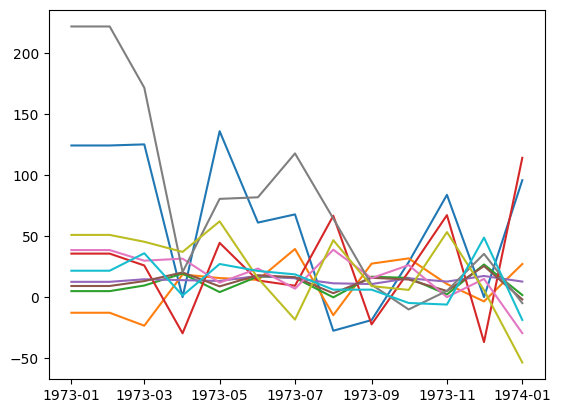

In [6]:
## simple imputation for one missing value(1973/1/1) in 10 banking indicators
## imputation method=use the following value

missing_var=list(full_info.loc[full_info.start==pd.Timestamp(1973,2,1)]['id'])
print(len(missing_var)) ## 10indicators for banking sector(1973-01-01 missing)

for var in missing_var:
    full_data.loc[pd.Timestamp(1973,1,1), var]=full_data.loc[pd.Timestamp(1973,2,1), var]
    
full_data.loc[[pd.Timestamp(1973,1,1),pd.Timestamp(1973,2,1)], missing_var]

plt.plot(full_data[missing_var][pd.Timestamp(1973,1,1):pd.Timestamp(1974,1,1)]);


In [7]:
use_varlist=list(full_info.loc[
    (full_info.start<=pd.Timestamp(1973,1,1))&
    (full_info.end>=pd.Timestamp(2022,12,1))
]['id'])+missing_var

#len(use_varlist)  ##207 features including target variable

discard_varlist=[x for x in list(full_info.id) if x not in use_varlist]

In [8]:
len(use_varlist), len(discard_varlist)

(197, 26)

In [9]:
## setting filtered_data using period(1973/1 ~ 2022/12)
full_data = full_data.replace(to_replace='.', value=np.nan)
full_data = full_data.astype('float64')

filtered_data = full_data[use_varlist][pd.Timestamp(1973,1,1):pd.Timestamp(2022,12,1)]

In [10]:
## checking if there another nan values for containing series
## there exists 3 series with missing values
## it is possible because we first filter the variables with 
## just metadata information of start_date, end_date
## if some missing values exist between the existing value in the series,
## the series will be detected at this point.

null_dict=dict(filtered_data.isna().sum())
null_list=[x for x in null_dict.keys() if null_dict[x]!=0]
print([(x, null_dict[x]) for x in null_list])
filtered_data[null_list].head(5)

[('CP3Mx', 1), ('COMPAPFFx', 1), ('UMCSENTx', 40), ('WPSID6222', 192), ('WPU142', 4)]


,CP3Mx,COMPAPFFx,UMCSENTx,WPSID6222,WPU142
date,,,,,
1973-01-01,5.77,-0.17,NaN,17.5,38.6
1973-02-01,6.17,-0.41,81.9,17.7,38.8
1973-03-01,6.76,-0.33,NaN,17.9,39.0
1973-04-01,7.13,0.01,NaN,18.0,39.0
1973-05-01,7.26,-0.58,77.0,18.2,39.0


In [11]:
null_list

['CP3Mx', 'COMPAPFFx', 'UMCSENTx', 'WPSID6222', 'WPU142']

In [12]:
## null_list[3]: drop due to too many missing values (missing values in certain period)
## null_list[0,1,2,3]: apply linear interpolation, 
## for 'UMCSENTx', the series changed from quarterly data to monthly data from 1978

null_list.remove('WPSID6222')  ## the variable to apply linear interpolation
use_varlist.remove('WPSID6222') ## the variable to use in the analysis
discard_varlist=discard_varlist+['WPSID6222']  ## the variable not to use in the analysis

In [13]:
## uncomment to figure out the index of missing value

# for var in null_list:
#     print('{}:'.format(var),filtered_data[filtered_data.isna()[var]==True][var])

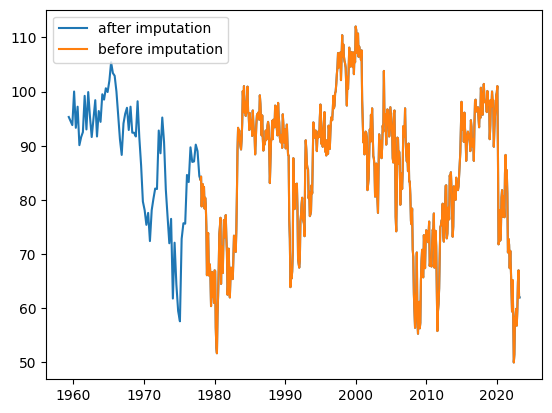

In [14]:
## imputation methods: linear interpolation
## the example plot is for 'UMCSENTx' (other 2 series has only one missing value)

fig, ax=plt.subplots()
ax.plot(full_data['UMCSENTx'].interpolate(method='linear'), label='after imputation')
ax.plot(full_data['UMCSENTx'], label='before imputation')
ax.legend()

for x in range(len(null_list)):
    full_data[null_list[x]]=full_data[null_list[x]].interpolate(method='linear')

In [26]:
len(use_varlist)

196

In [16]:
## setting imputed_data using period(1973/1 ~ 2022/12)
imputed_data=full_data[use_varlist][pd.Timestamp(1973,1,1):pd.Timestamp(2022,12,1)]
dict(imputed_data.dtypes)
imputed_data=imputed_data.astype('float64')

In [17]:
# dot_list=[x[0] for x in dict(imputed_data.dtypes).items() if (x[1]!=np.dtype('float64'))&(x[1]!=np.dtype('int64'))]
# print(dot_list)

# print(filtered_data[dot_list[0]].value_counts()['.']) ## have to drop -- too many missing values
# print(filtered_data[dot_list[1]].value_counts()['.']) ## linear interpolation

# ## too many missing values --> drop the variable
# use_varlist.remove(dot_list[0])
# discard_varlist=discard_varlist+[dot_list[0]]

# ## afew missing values --> apply linear interpolation
# full_data[dot_list[1]]=full_data[dot_list[1]].interpolate(method='linear')
# imputed_data[dot_list[1]]=imputed_data[dot_list[1]].interpolate(method='linear')

# ## dtype error: dtype(0) --> dtype('float64')
# imputed_data[dot_list[2]]=imputed_data[dot_list[2]].astype('float64')
# plt.plot(imputed_data[dot_list[2]])

In [18]:
imputed_data['WPU142']

date
1973-01-01     38.600
1973-02-01     38.800
1973-03-01     39.000
1973-04-01     39.000
1973-05-01     39.000
               ...   
2022-08-01    295.772
2022-09-01    296.865
2022-10-01    297.361
2022-11-01    297.779
2022-12-01    298.741
Name: WPU142, Length: 600, dtype: float64

In [19]:
var_list=[]
pvalue=[]

for idx, var in enumerate(use_varlist):
    X=imputed_data[var].values
    result = adfuller(X)
    var_list.append(var)
    pvalue.append(result[1])

adf_df=pd.DataFrame({'var':var_list,'pvalue':pvalue})
adf_df['stationary']=adf_df['pvalue'].apply(lambda x:1 if x<0.1 else 0)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#  print('\t%s: %.3f' % (key, value))

In [20]:
nonst_varlist=adf_df.loc[adf_df.stationary==0]
full_info=pd.read_csv(syspath+'/full_info.csv')

In [27]:
## see non-stationary series
print(len(nonst_varlist))
list(nonst_varlist.merge(full_info, how='left', left_on='var', right_on='id')['title'])

127


['Real Personal Income',
 'Real personal income excluding current transfer receipts',
 'Real personal consumption expenditures (chain-type quantity index)',
 'Real Manu.  and Trade Industries Sales',
 'Retail and Food Services Sales',
 'Industrial Production: Total Index',
 'Industrial Production: Final Products and Nonindustrial Supplies',
 'Industrial Production: Final Products',
 'Industrial Production: Consumer Goods',
 'Industrial Production: Durable Consumer Goods',
 'Industrial Production: Non-Durable Consumer Goods',
 'Industrial Production: Equipment: Business Equipment',
 'Industrial Production: Materials',
 'Industrial Production: Durable Goods Materials',
 'Industrial Production: Non-Durable Goods Materials',
 'Industrial Production: Manufacturing (SIC)',
 'Industrial Production: Non-Durable Consumer Energy Products: Residential Utilities',
 'Industrial Production: Non-Durable Consumer Energy Products: Fuels',
 'Help-Wanted Index for United States',
 'Ratio of Help Wanted/N

However, we will use time-series classification methods which won't depend on the stationarity of inputs such as Random Forest, Support Vector Machines, Gradient Boosting(XGBoost), Deep Neural Networks(LSTM, GRU, DBN), Dynamic Time Warping(DTW)

In [28]:
y_list=list(full_info[full_info.group==0]['id'])
X_list=[x for x in use_varlist if x not in y_list]

len(discard_varlist), len(use_varlist), len(X_list), len(y_list)

(27, 196, 187, 9)

In [29]:
## explanatory variables and dependent variables
Xy_data=imputed_data[use_varlist]
y_data=imputed_data[y_list]
X_data=imputed_data[X_list]

Xy_data.to_csv (syspath+'/Xy_data.csv', index = True, header=True)
X_data.to_csv (syspath+'/X_data.csv', index = True, header=True)
y_data.to_csv (syspath+'/y_data.csv', index = True, header=True)

In [30]:
pd.read_csv(syspath+'/y_data.csv', index_col='date', parse_dates=True).head(5)

,CLI_MA,CLI_N,CLI_T,GDP_RTT,GDP_N,GDP_T,y_nber,y_oecd,y_agg
date,,,,,,,,,
1973-01-01,103.8,103.4,32.5,102.7,102.4,31.3,0.0,0.0,0.0
1973-02-01,103.7,103.3,32.6,103.1,102.6,31.4,0.0,0.0,0.0
1973-03-01,103.4,103.1,32.6,103.3,102.8,31.5,0.0,0.0,0.0
1973-04-01,103.1,102.8,32.5,103.4,103.0,31.5,0.0,0.0,0.0
1973-05-01,102.7,102.4,32.5,103.4,103.0,31.6,0.0,0.0,0.0


In [31]:
pd.read_csv(syspath+'/X_data.csv', index_col='date', parse_dates=True).tail(5)

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,H8B1047NCBCMG,H8B1048NCBCMG,H8B1058NCBCMG,H8B1091NCBCMG,H8B1151NCBCMG,H8B1152NCBCMG,H8B3053NCBCMG,H8B3094NCBCMG,H8B3095NCBCMG,H8B3305NCBCMG
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,17761.376,14618.2,128.437,1571086.0,680500.0,103.2344,102.1993,102.2355,103.0030,107.1349,...,-62.5,-2.4,0.4,-11.1,2.1,3.4,1.2,-3.6,-6.8,7.8
2022-09-01,17784.666,14653.2,128.769,1571994.0,680387.0,103.5283,102.2519,102.1793,102.7122,106.6796,...,26.4,-49.1,-6.2,-20.4,-6.7,-5.4,-4.5,36.0,27.8,5.9
2022-10-01,17872.733,14683.1,129.111,1570326.0,687498.0,103.4114,102.5001,102.6171,103.2432,108.1173,...,-193.5,-21.8,-9.3,-8.3,-2.9,-2.4,10.7,21.1,36.8,11.1
2022-11-01,17916.642,14715.9,128.577,1555521.0,678482.0,103.0719,102.1957,102.2274,103.0934,105.7646,...,-169.2,-0.2,-2.3,-0.1,4.7,5.2,29.7,34.6,32.9,5.1
2022-12-01,17936.624,14735.4,128.328,1578873.0,673619.0,101.4761,100.9352,101.3295,102.4122,104.7582,...,-53.7,-3.7,-0.5,24.1,0.3,-1.9,-18.0,23.8,-18.6,-3.9
